<a href="https://colab.research.google.com/github/alina-bogdanovskaya/ML_in_Business_Mar2023/blob/lesson7/ML_in_business_HW07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import sys
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

# models
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
wine = pd.read_csv('/content/drive/MyDrive/GB/ML in business/datasets/wine/white_wine.csv', sep=';')

In [3]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [7]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [8]:
def evaluate_results(y_test, y_pred):
    print('Classification results:')
    f1 = f1_score(y_test, y_pred, zero_division=1)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_pred)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_pred, average='binary', zero_division=1)
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_pred, average='binary', zero_division=1)
    print("precision: %.2f%%" % (prc * 100.0)) 

In [20]:
cont_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 
                'density', 'pH', 'sulphates', 'alcohol']

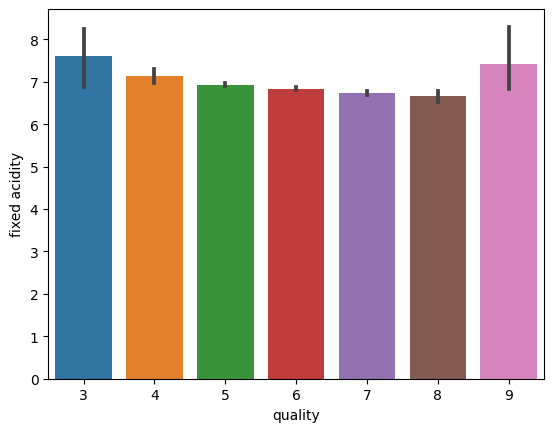

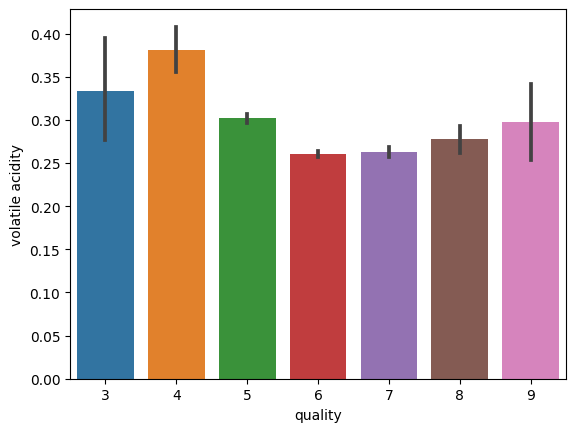

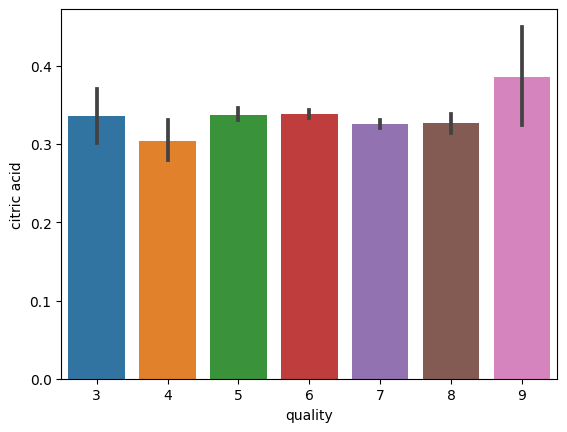

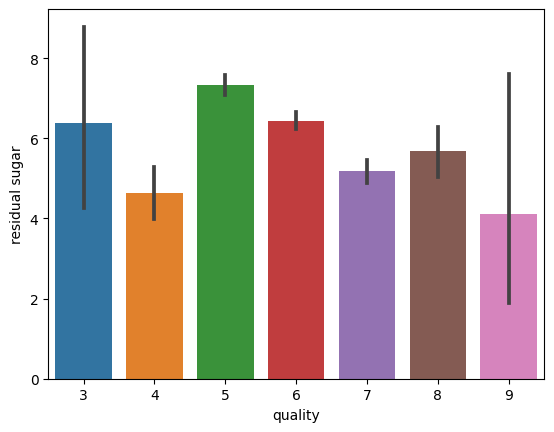

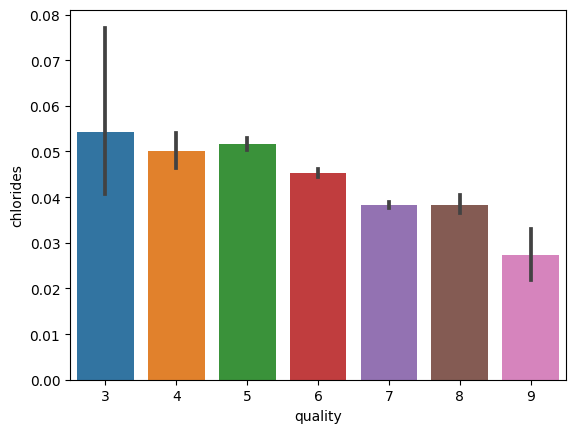

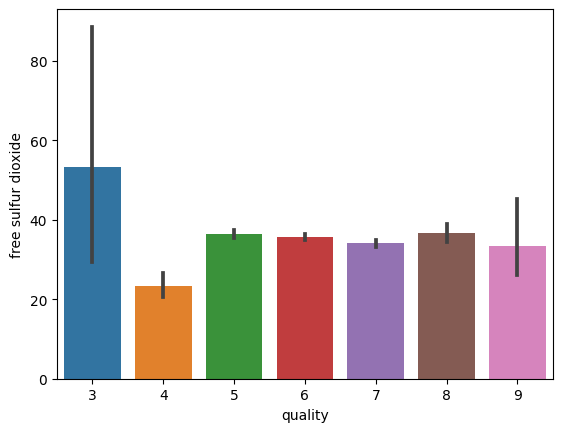

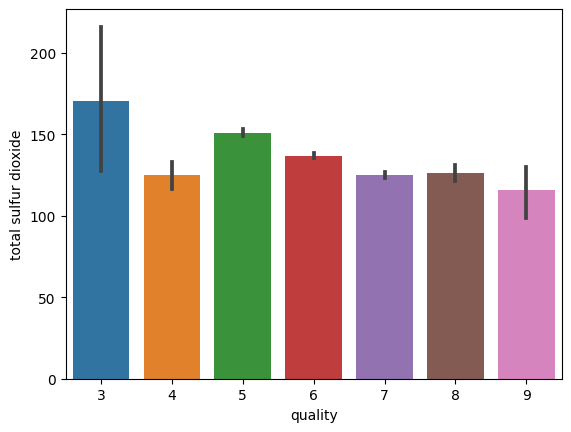

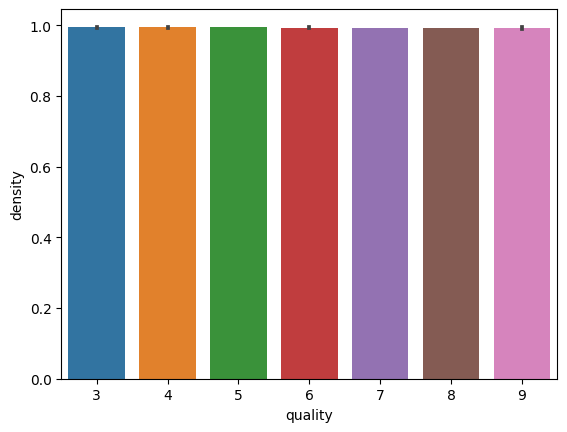

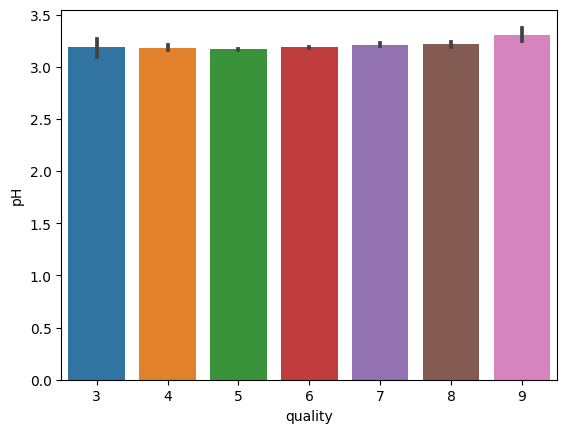

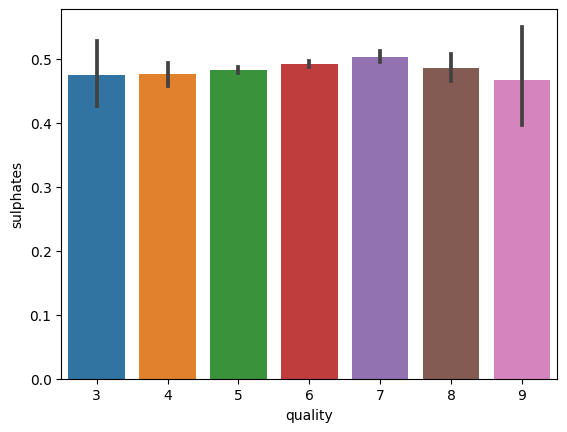

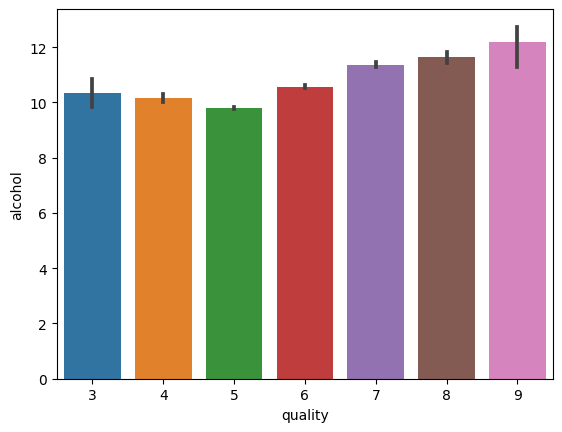

In [10]:
for col in cont_columns:
  plt.figure()
  sns.barplot(data=wine, x='quality', y=col)

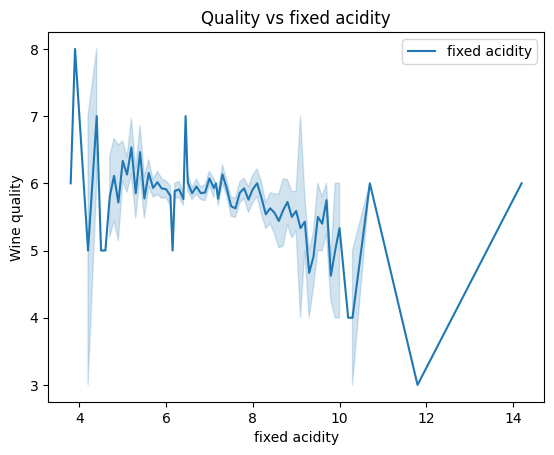

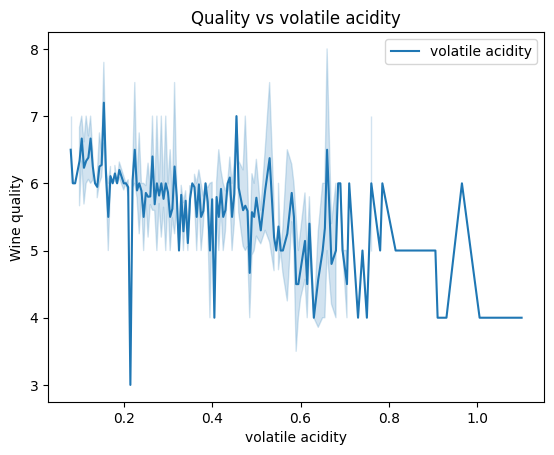

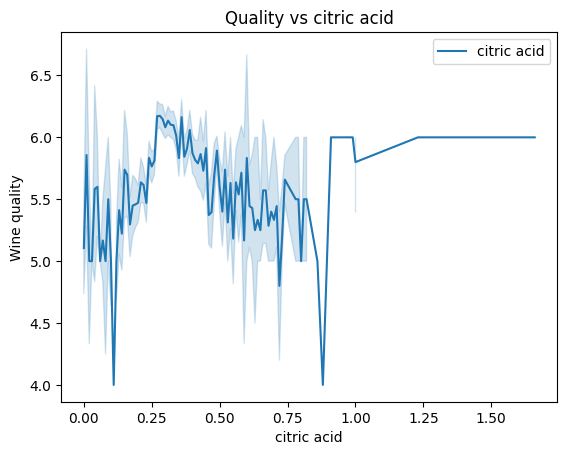

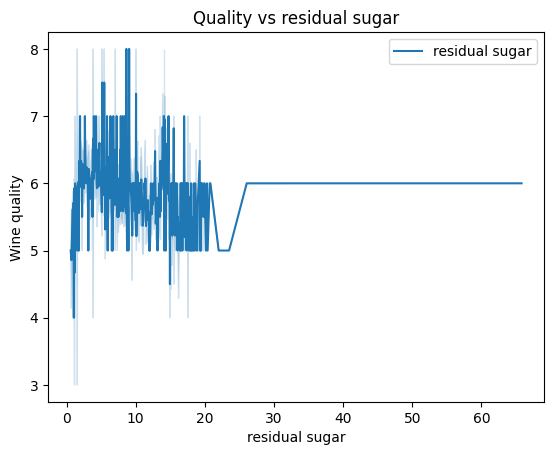

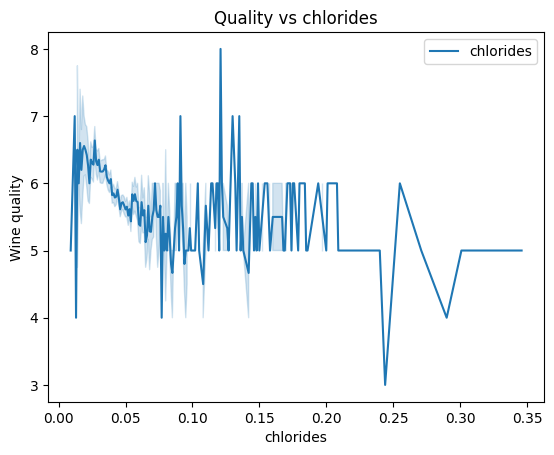

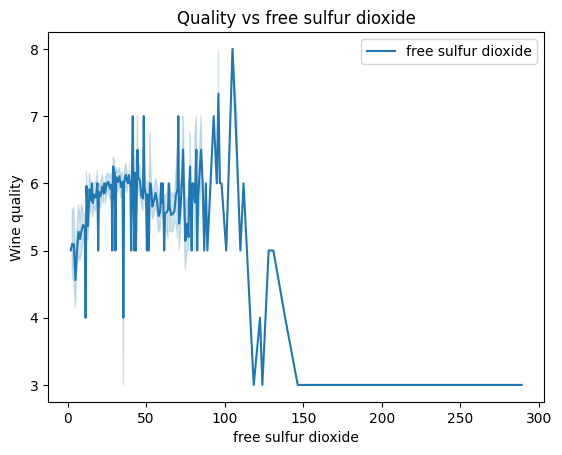

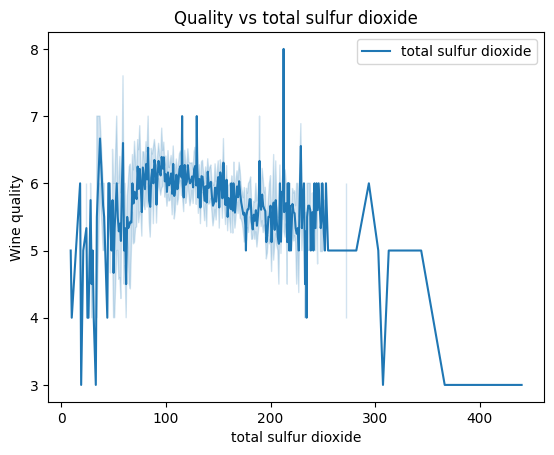

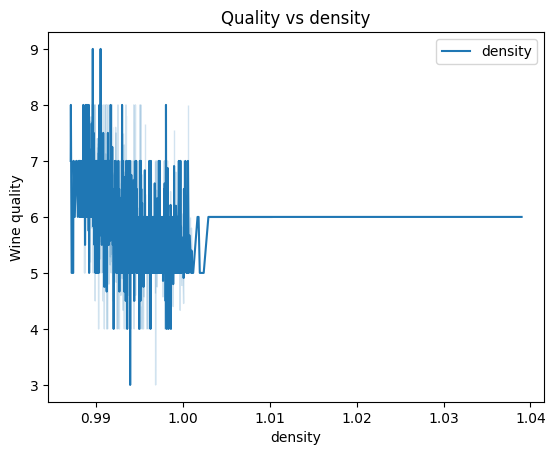

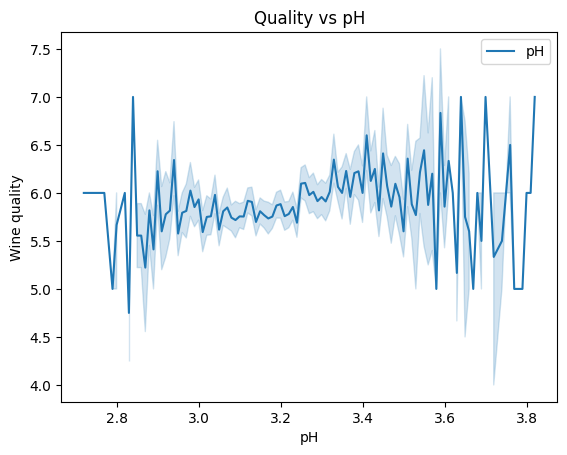

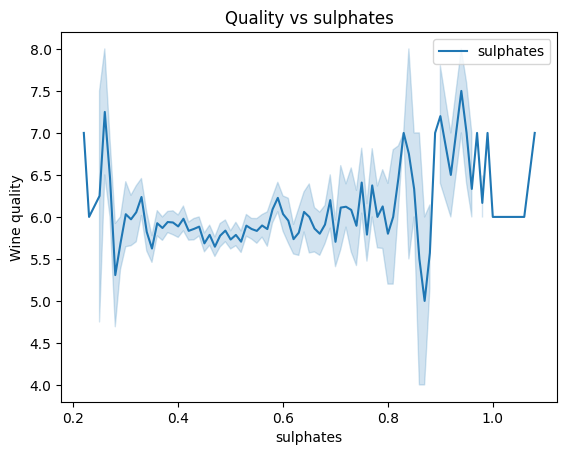

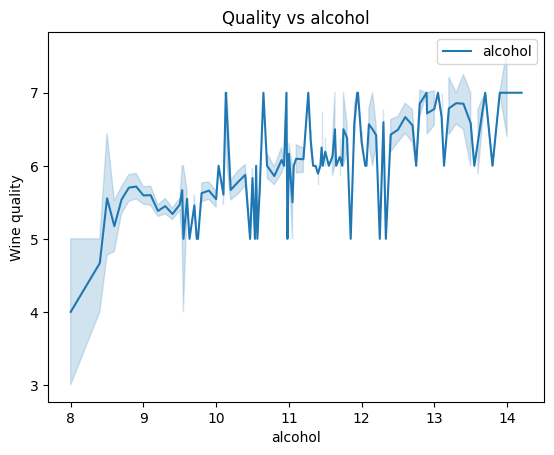

In [23]:
for col in cont_columns:
  plt.figure()
  sns.lineplot(x=col, y='quality', data=wine, label=f'{col}')
  plt.legend()
  plt.xlabel(f'{col}')
  plt.ylabel('Wine quality')
  plt.title(f'Quality vs {col}')
  plt.show()

In [4]:
wine.quality.value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [28]:
wine['target'] = wine.quality.values
wine.target.replace([[3, 4, 5], [6, 7, 8, 9]], [0, 1], inplace=True)
wine.target.value_counts()

1    3258
0    1640
Name: target, dtype: int64

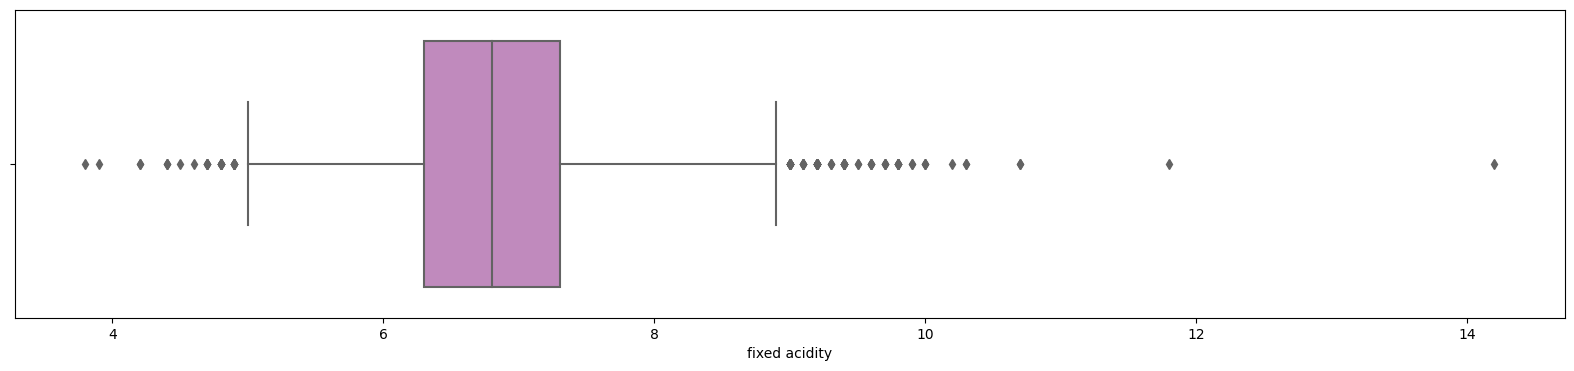

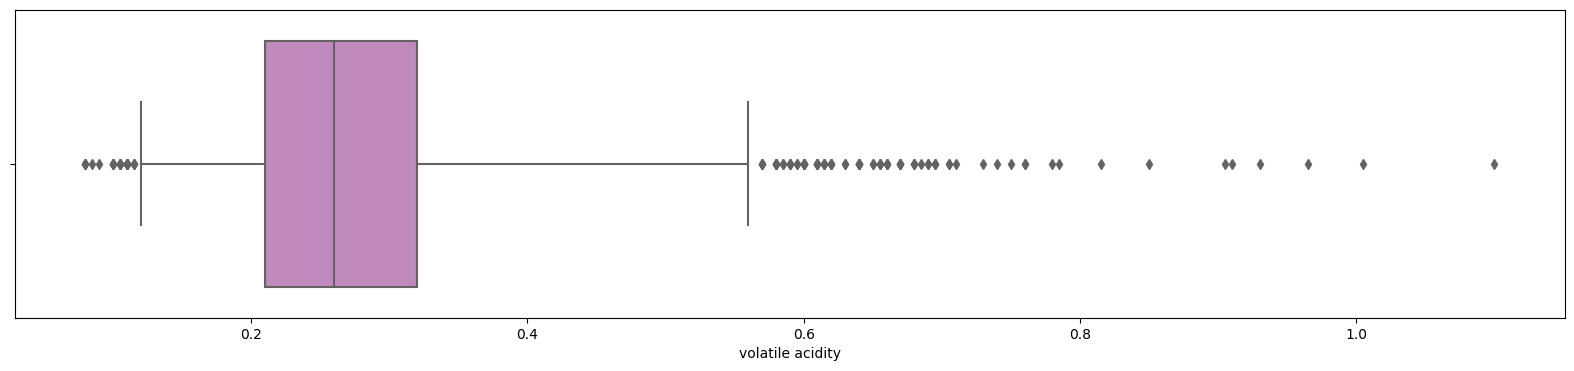

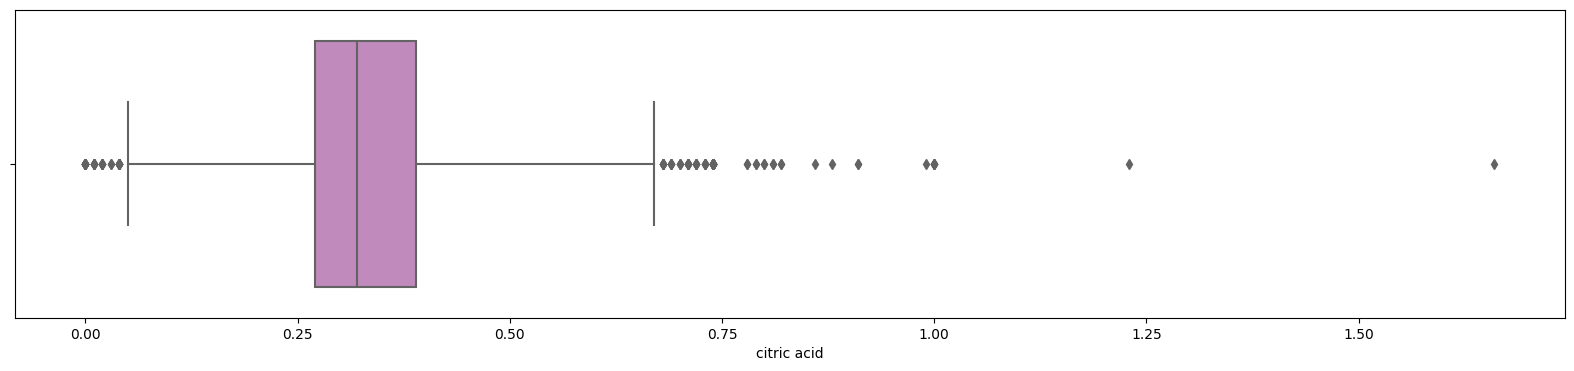

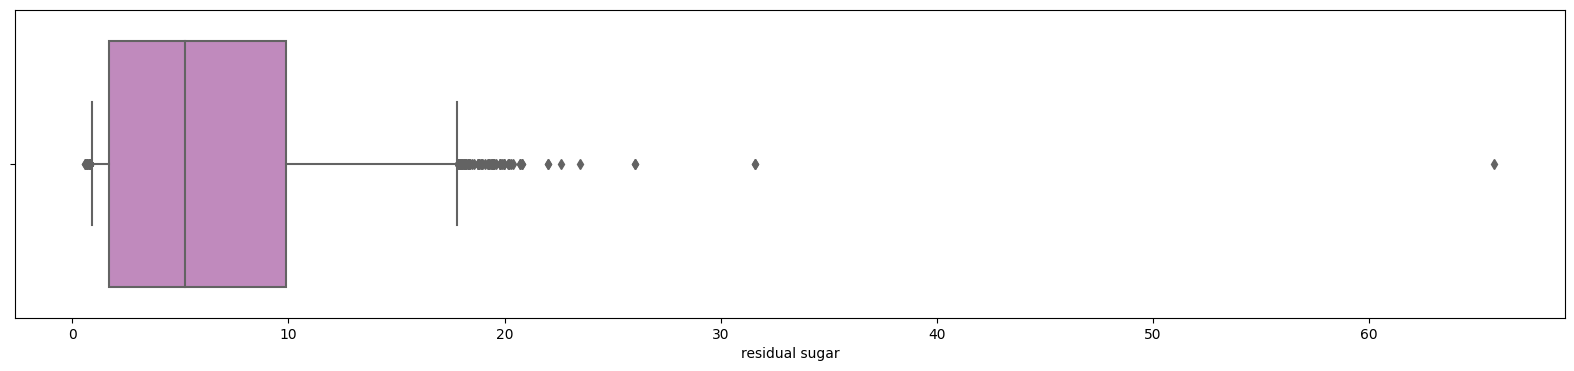

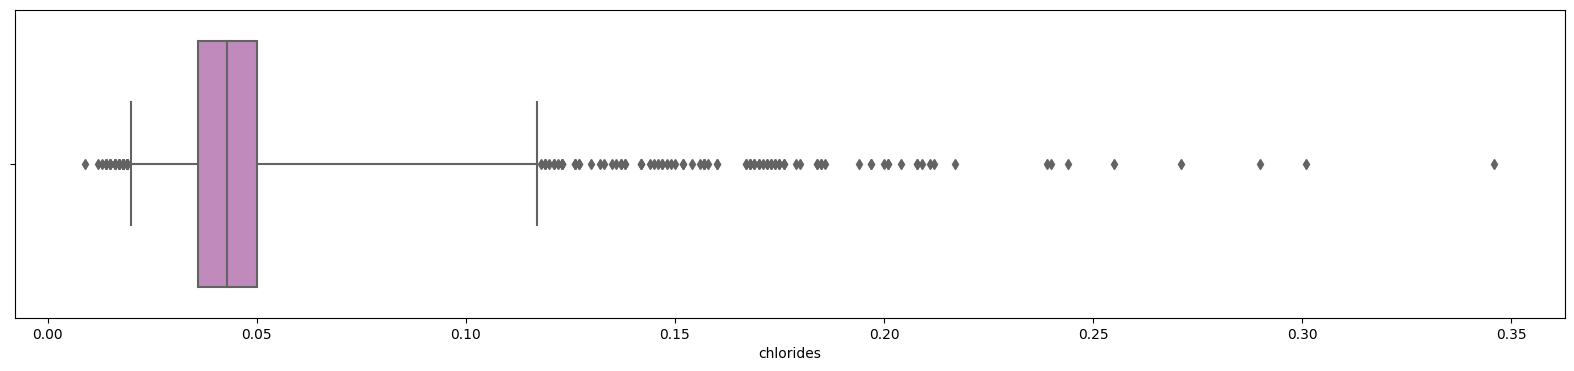

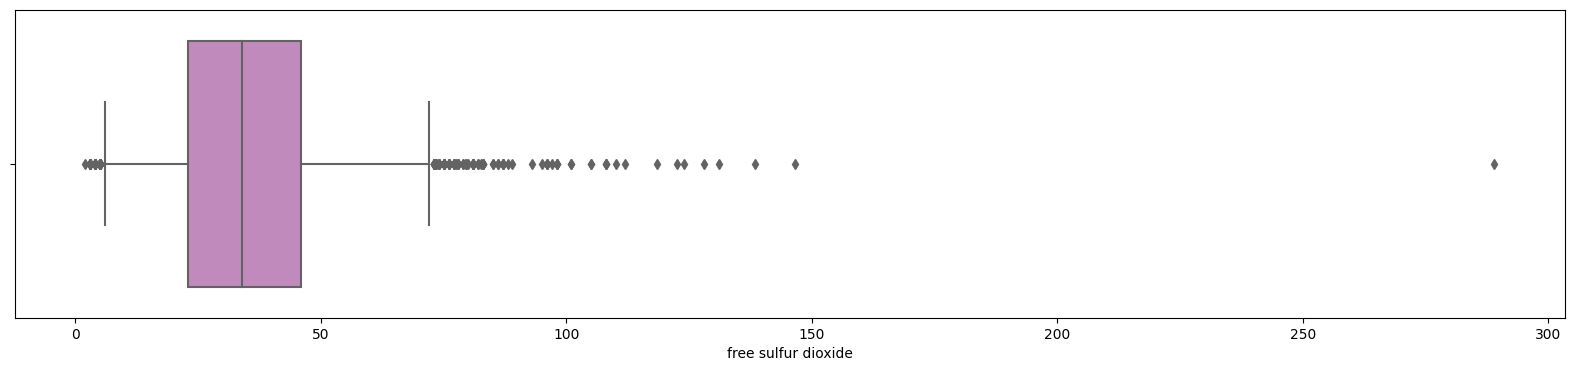

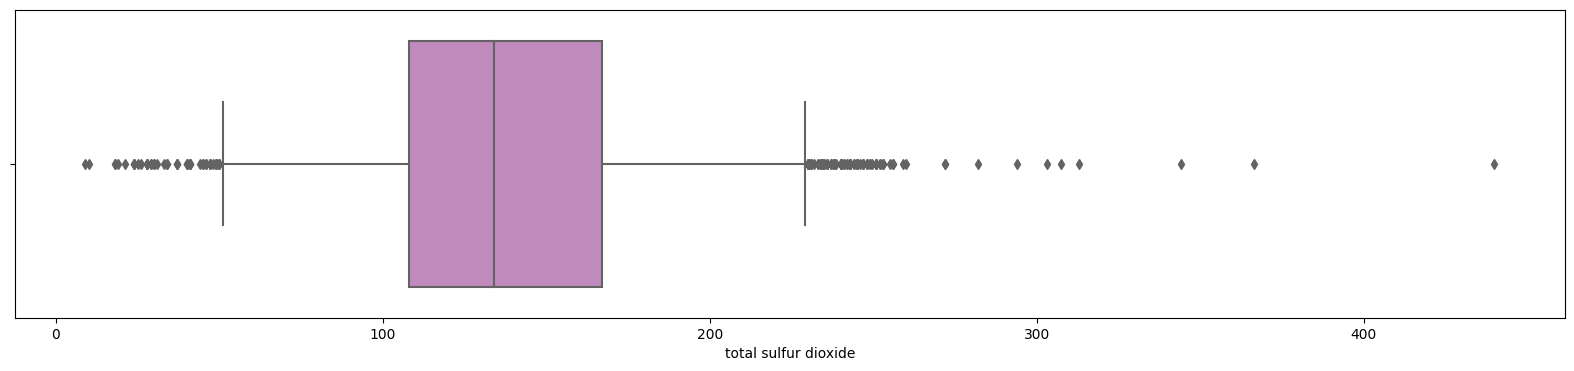

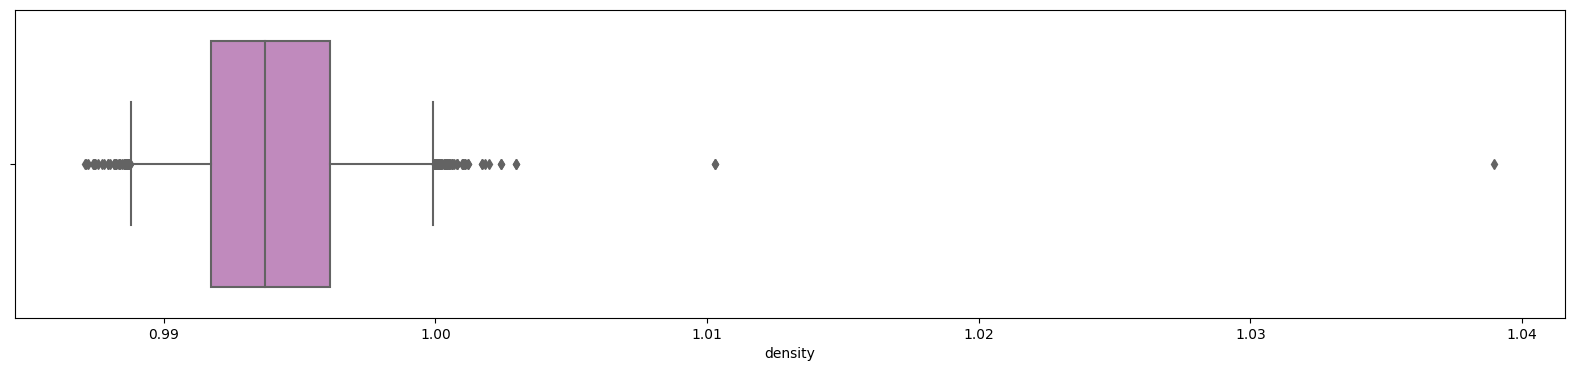

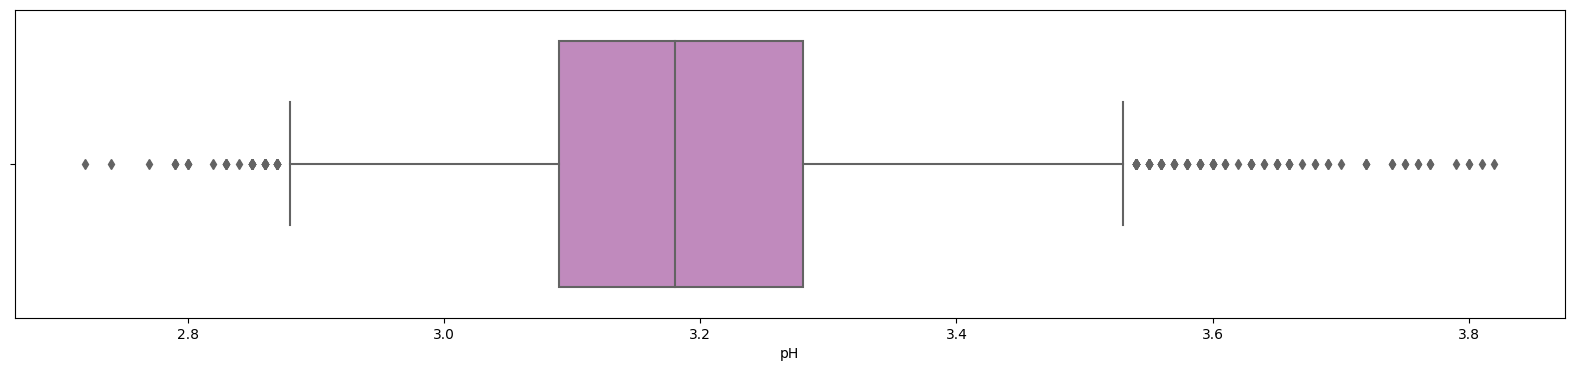

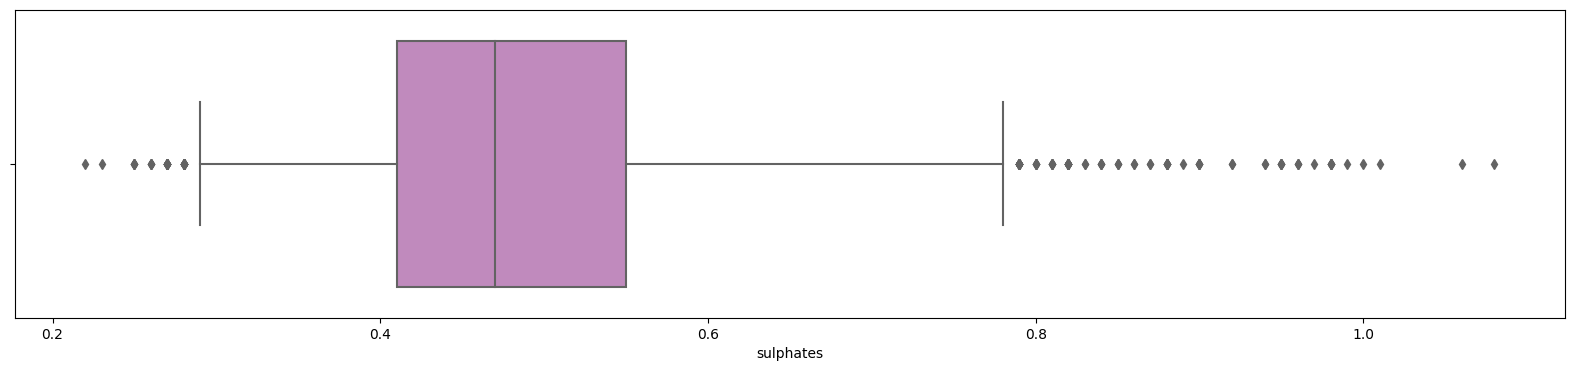

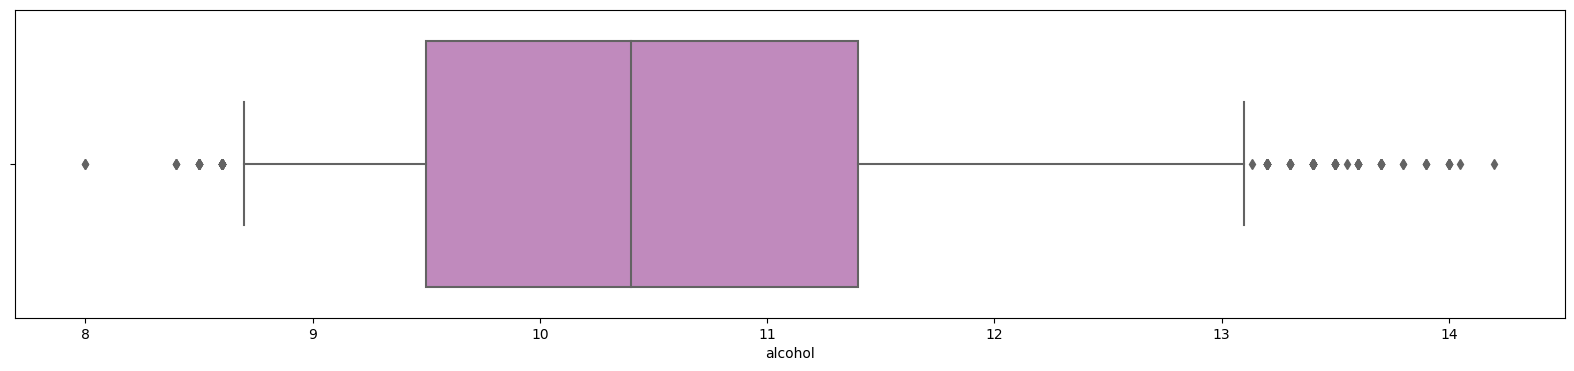

In [16]:
for col in cont_columns:
    plt.figure(figsize=(20, 4))
    sns.boxplot(x=wine[col], whis=(1, 98), saturation=0.5, color='orchid')

In [24]:
class DataPreprocessing:
    
    def __init__(self):
        self.medians = None
        self.quanlile_1 = None
        self.quantile_98 = None
                
    def fit(self, df):
        """Сохранение статистик""" 
              
        self.medians = df.median()
        self.quanlile_1 = df.quantile(0.01) 
        self.quantile_98 = df.quantile(0.98)
        
                                
    def transform(self, df):
        """Трансформация данных"""

        medians = self.medians
        quantile_1 = self.quanlile_1
        quantile_98 = self.quantile_98

        cont_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
                        'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 
                        'density', 'pH', 'sulphates', 'alcohol']

        for col in cont_columns:
            df.loc[(df[col] < quantile_1[col]) | (df[col] > quantile_98[col]), col] = medians[col]

        return df

In [25]:
X = wine.drop(['quality', 'target'], axis=1)
y = wine.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [26]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [9]:
final_transformers = list()

for col in cont_columns:
    col_transformer = Pipeline([
                ('selector', NumberSelector(key=col)),
                ('standard', StandardScaler())
            ])
    
    final_transformers.append((col, col_transformer))

feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [32]:
model = Pipeline([
    ('features', feats),
    ('classifier', XGBClassifier(learning_rate=0.5, scale_pos_weight=2))
])

model.fit(X_train, y_train)
pred = model.predict(X_test)

evaluate_results(y_test, pred)

Classification results:
f1: 87.86%
roc: 78.72%
recall: 90.94%
precision: 84.99%


In [33]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 10.3 MB/s eta 0:00:00


In [34]:
import shap

In [49]:
model = XGBClassifier(learning_rate=0.5, scale_pos_weight=2)

model.fit(X_train, y_train)
pred = model.predict(X_test)

evaluate_results(y_test, pred)

Classification results:
f1: 87.81%
roc: 78.59%
recall: 90.94%
precision: 84.89%


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


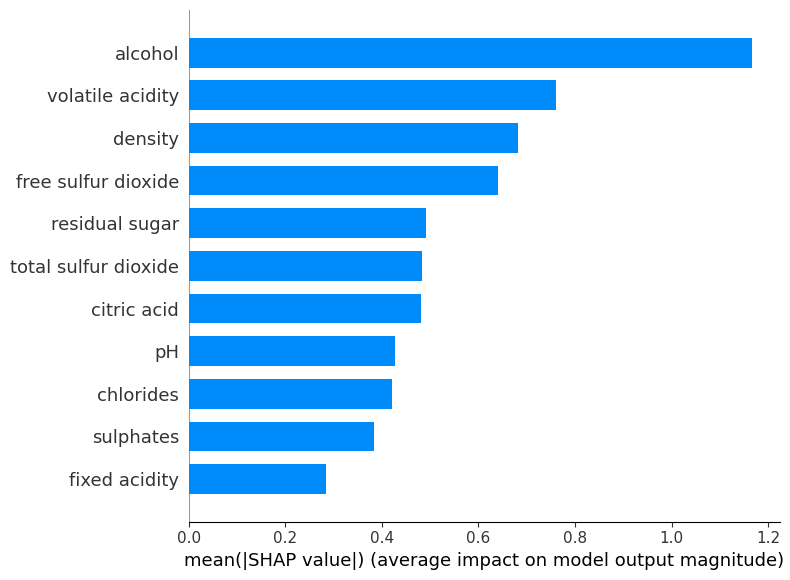

In [67]:
explainer = shap.TreeExplainer(model)
shap_values_all = explainer.shap_values(X_test)
shap.summary_plot(shap_values_all, X_test, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


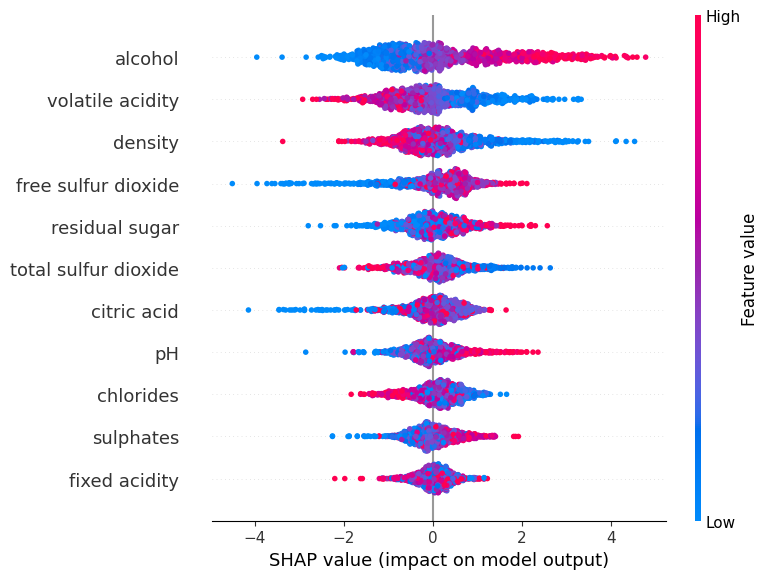

In [68]:
shap.summary_plot(shap_values_all, X_test)

In [70]:
shap.initjs()
idx = 1063
shap.force_plot(explainer.expected_value, shap_values_all[idx,:], X_test.iloc[idx,:])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


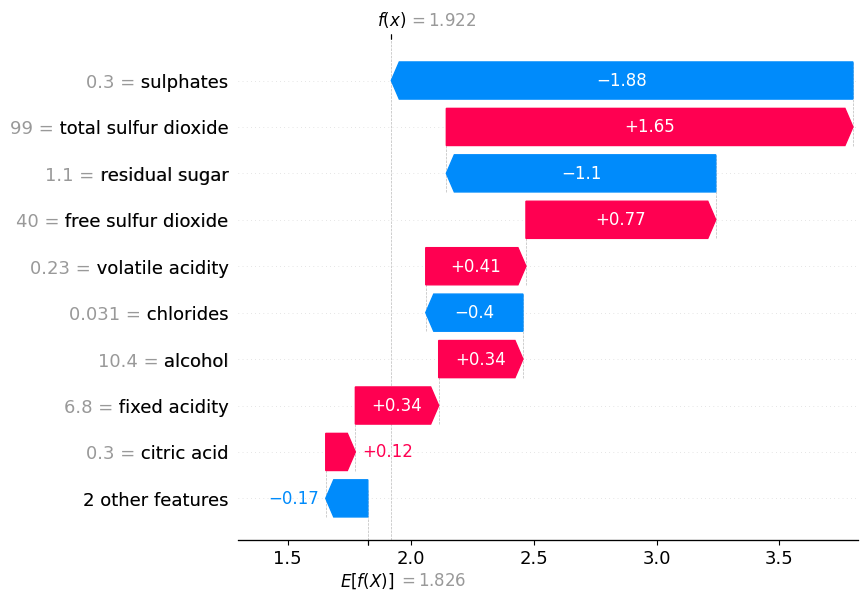

In [71]:
shap_values_one = explainer(X_test.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

In [72]:
n=10
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values_all[:n], X_test.iloc[:n])

In [63]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
import eli5
from eli5.sklearn import PermutationImportance
from eli5 import show_prediction

In [64]:
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names = cont_columns)

Weight,Feature
0.1053 ± 0.0110,alcohol
0.0739 ± 0.0089,density
0.0724 ± 0.0114,volatile acidity
0.0652 ± 0.0055,free sulfur dioxide
0.0540 ± 0.0057,total sulfur dioxide
0.0529 ± 0.0056,residual sugar
0.0430 ± 0.0054,pH
0.0407 ± 0.0021,citric acid
0.0341 ± 0.0034,chlorides
0.0303 ± 0.0035,sulphates


In [65]:
show_prediction(model, X_train.iloc[idx], feature_names=X_train.columns.tolist(), 
                show_feature_values=True)